# Los Simpsons con Big Data

## ETL

Implementación de la primera parte de la arquitectura. En la práctica se puede **prototipar** este ETL en un cuaderno de Jupyter para experimentar rápido y dejar algo funcional. Al finalizar, lo más adecuado es implementarlo en un script utilizando prácticas de **código de producción**.

### Extracción

Se desea automatizar la extracción de datos y no hacer un típico _copy and paste_, para lo cual se va a implementar un en un webscrapper que haga un crawl sobre las tablas del HTML.

En la aplicación se va a utilizar un _webscrapper_ que ya está implementado en Python dentro de funciones de la librería `pandas`.

In [1]:
import os
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import boto3
import awswrangler as wr

# Open project config file
with open("config.yml", "r") as file:
    config = yaml.safe_load(file); file.close()

In [2]:
# Scrapp wikipedia url
PATH_EPISODES = config['scrapper']['url']
simpsons_raw = pd.read_html(PATH_EPISODES)

# Print total scrapped objects
len(simpsons_raw)

23

### Transformación

Haciendo una inspección rápida de la página de Wikipedia, se puede identificar que existe 20 tablas de información relacionada a los episodios. Sin embargo, es necesario hacer alguna modificaciones a cada una antes de incorporarlas a AWS S3.

In [3]:
# List of seasons and movies index
seasons = np.arange(
    config['scrapper']['seasons'][0]
    ,config['scrapper']['seasons'][1]+1)
movie = config['scrapper']['movie']

# Season counter
k = 1
table = pd.DataFrame()
print(f'Initial Dim: {table.shape}')

# File name counter
for idx in seasons:
    # Skip movie from ETL
    if idx == movie:
        continue

    # Data transformation
    transformed_table = (
        # Filter data object
        simpsons_raw[idx]
        # Rename table columns
        .rename(columns=config['scrapper']['names'])
        .assign(
            # Add season indicator
            season = k,
            # Convert datestr to datetime
            air_date = lambda df_: pd.to_datetime(df_.air_date),
            # Replace , with ; from data
            title = lambda df_: df_.title.str.replace(',', ';'),
            director = lambda df_: df_.title.str.replace(',', ';'),
            writer = lambda df_: df_.title.str.replace(',', ';'),
            # Remove wikipedia reference box
            viewers = lambda df_: df_.viewers.str.extract(r'([0-9]*.[0-9]*)')
        ))
    
    table = pd.concat([table, transformed_table], axis=0)

    k += 1

print(f'Final Dim: {table.shape}')


Initial Dim: (0, 0)
Final Dim: (441, 9)


In [4]:
# Save table
table.to_csv(os.path.join(config['path']['episodes'], 'episodes.csv'), index=False)

### Carga

Como último paso del Pipeline, se hace la carga de datos al _data lake_ para que puedan ser consumidos por algún otro usuario o servicio.

In [5]:
# AWS S3 client and bucket
s3 = boto3.client('s3')
BUCKET = config['etl']['target_bucket']

# Files to upload
files = [
    x for x in os.listdir(config['path']['episodes'])
    if x.__contains__('.csv')
    ]
files.sort()

# Upload table to cloud
for file in files:
    # Build file path
    file = os.path.join(config['path']['episodes'], file)
    
    # Upload to AWS S3
    s3.upload_file(
        Filename=file,
        Bucket=BUCKET,
        Key=file)

print('Job done!')

Job done!


## ELT

Una vez subidos los datos a un datalake, entonces se pued establecer una conexión para trabajar con ellos.

In [6]:
# Objeto de glue catalog
glue = boto3.client('glue')

Primero se tiene que crear una tabla para que Athena pueda conectarse a los datos cargados en la sección anterior.

In [7]:
query = '''
CREATE EXTERNAL TABLE IF NOT EXISTS `simpsons`.`episodes` (
    `id_overall` string,
    `id_season` string,
    `title` string,
    `director` string,
    `writer` string,
    `air_date` string,
    `code` string,
    `viewers` string,
    `season` string
)
COMMENT "Catalog of Simpsons seasons."
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
WITH SERDEPROPERTIES ('field.delim' = ',')
STORED AS INPUTFORMAT 'org.apache.hadoop.mapred.TextInputFormat'
OUTPUTFORMAT 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION 's3://itam-analytics-camm961001/simpsons/raw/episodes/'
TBLPROPERTIES ('classification' = 'csv', "skip.header.line.count"="1");
'''

wr.athena.read_sql_query(query, database="simpsons", ctas_approach=False)

""


Después se llaman los datos al notebook para su análisis

In [16]:
query = '''
SELECT
    a.season,
    a.title,
    a.viewers,
    b.guest_star
FROM simpsons.episodes AS a
LEFT JOIN simpsons.guests AS b
ON a.season = b.season
AND a.code = b.prod_code;
'''

episodes_guests = wr.athena.read_sql_query(query, database='simpsons', ctas_approach=False)

episodes_guests = (
    episodes_guests
    .assign(
        # Remove " from title
        title = lambda df_: df_.title.str.replace('"', ''),
        # Convert to numeric
        season = lambda df_: df_.season.astype(int),
        viewers = lambda df_: df_.viewers.astype(float),
        guest_flag = lambda df_: ~pd.isna(df_.guest_star)
    )
)

episodes_guests.head()

,season,title,viewers,guest_star,guest_flag
0,1,Simpsons Roasting on an Open Fire,26.7,<NA>,False
1,1,Bart the Genius,24.5,Marcia Wallace,True
2,1,Homer's Odyssey,27.5,Marcia Wallace,True
3,1,Homer's Odyssey,27.5,Sam McMurray,True
4,1,There's No Disgrace Like Home,20.2,<NA>,False


Text(0, 0.5, 'Viewers')

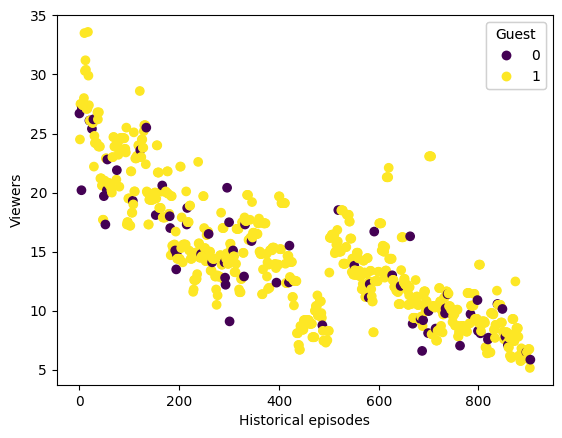

In [38]:
fig, ax = plt.subplots()

scatter = ax.scatter(
    x=episodes_guests.index
    ,y=episodes_guests['viewers']
    ,c=episodes_guests['guest_flag']
)

legend = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper right", title="Guest")
ax.add_artist(legend)

ax.set_xlabel('Historical episodes')
ax.set_ylabel('Viewers')

<Axes: xlabel='season'>

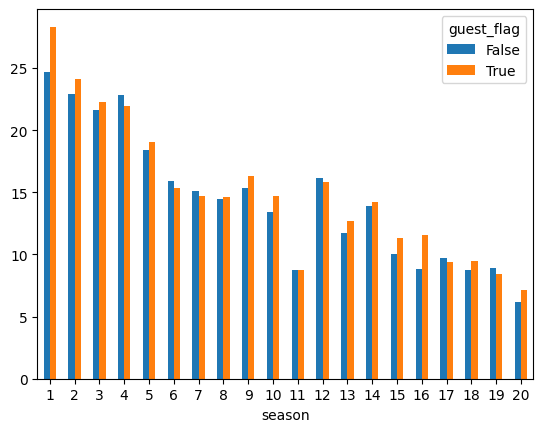

In [37]:
(
    episodes_guests
    .pivot_table(
        values='viewers'
        ,index='season'
        ,columns='guest_flag'
    )
    .plot.bar(rot=0)
)